<a href="https://colab.research.google.com/github/adtitovich/dsml-17/blob/main/m5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание задания:
В домашнем задании нужно улучшить метрики RMSE, R2 модели линейной регрессии путем работы с данными, а именно проведения разведочного анализа данных. В качестве датасета необходимо загрузить данные о недвижимости Калифорнии из библиотеки [sklearn.datasets](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html). Целевая переменная – MedHouseVal. Прочитать информацию о признаках датасета можно, выполнив следующий код – print(fetch_california_housing().DESCR).

#Этапы работы:
**1. Получите данные и загрузите их в рабочую среду.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import IsolationForest

In [2]:
housing = fetch_california_housing(as_frame=True)
data = pd.DataFrame(data= np.c_[housing['data'], housing['target']],
                     columns= housing['feature_names'] + ['MedHouseVal'])

X = data.drop(columns = ['MedHouseVal'])
y = data['MedHouseVal']

data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


**2. Проверьте данные на наличие пропусков. Удалите их в случае обнаружения.**

In [3]:
# пропусков нет
data.isna().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

**3. Разделите выборку на обучающее и тестовое подмножества. 80% данных оставить на обучающее множество, 20% - на тестовое.**

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

**4. Постройте модель линейной регрессии. Вычислите метрики RMSE, R2 на обучающем и тестовом множестве.**

In [5]:
# строим модель
model = LinearRegression().fit(X_train, y_train)

In [6]:
# вычисляем метрики
df_metrics = pd.DataFrame({'RMSE':[mean_squared_error(y_test, model.predict(X_test), squared=False)],
                           'R2':[r2_score(y_test, model.predict(X_test))]},
                          index = ['Линейная регрессия'])

pd.DataFrame({'Обучение':[mean_squared_error(y_train, model.predict(X_train), squared=False), 
                          r2_score(y_train, model.predict(X_train))], 
              'Тест':[mean_squared_error(y_test, model.predict(X_test), squared=False), 
                      r2_score(y_test, model.predict(X_test))]}, 
             index = ['RMSE', 'R2'])

,Обучение,Тест
RMSE,0.725864,0.725998
R2,0.604309,0.604162


**5. Постройте график распределения целевой переменной. Сделайте вывод. Присутствуют ли в этом признаке выбросы?**

<Axes: xlabel='MedHouseVal', ylabel='Count'>

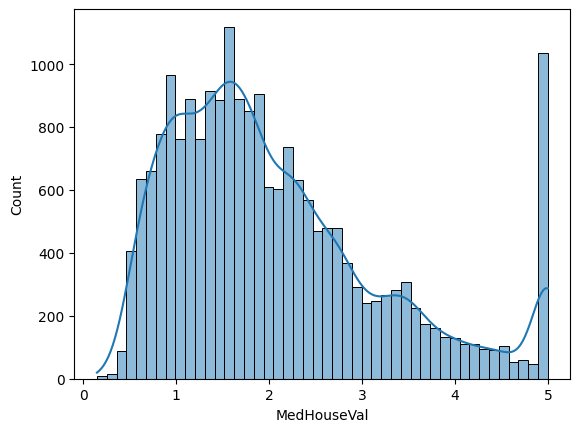

In [7]:
sns.histplot(y, kde=True)

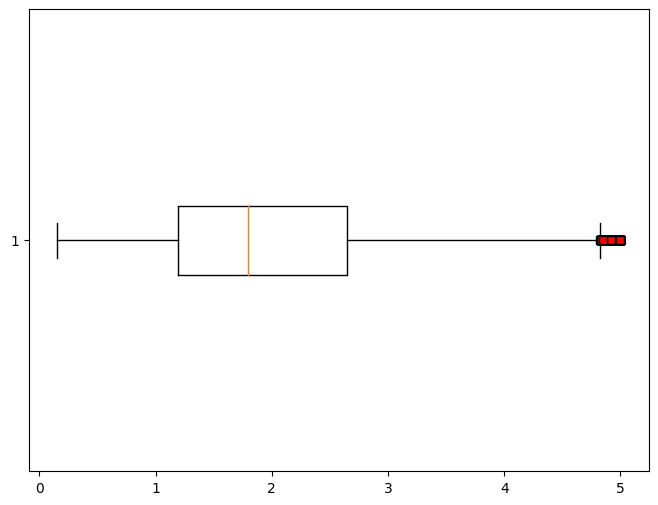

In [8]:
red_square = dict(markerfacecolor='r', marker='s') # выделим предполагаемые выбросы
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(y, vert=False, flierprops=red_square)
plt.show()

In [9]:
# границы "усов"
iqr = y.quantile(0.75) - y.quantile(0.25)
lower_bound = y.quantile(0.25)-1.5*iqr
upper_bound = y.quantile(0.75)+1.5*iqr
print(lower_bound, upper_bound)

-0.9808749999999995 4.824124999999999


Можно предположить, что значении целевой переменной более upper_bound является выбросами. 

In [10]:
#отбросим эти выбросы
data = data[data['MedHouseVal'] <= upper_bound]

**6. Посчитайте и выведите корреляционную матрицу. Убедитесь, что ячейки матрицы поделены на цветные категории, в ячейках указано числовое значение корреляции.   
a. Сделайте выводы.   
b. Удалите признаки на основании полученных значений, выводов.   
c. Повторите п. 3, п. 4 на измененных данных.**

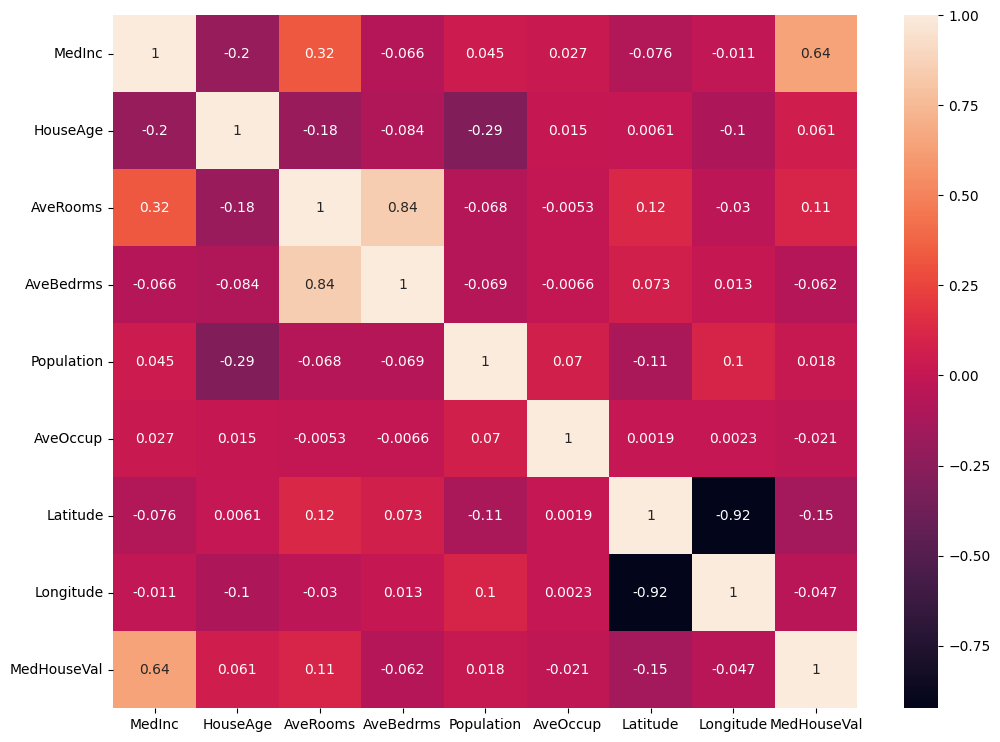

In [11]:
plt.figure(figsize=(12, 9))
sns.heatmap(data.corr(), annot = True)
plt.show()

У переменных AveRooms и	AveBedrms сильная положительная связь. У переменных Latitude и Longitude - сильная отрицательная связь.  
У целевой переменной сильная корреляция с MedInc

In [12]:
X = data.drop(columns = ['MedHouseVal'])
y = data['MedHouseVal']

# удалим признаки AveRooms и Longitude
X = X.drop(columns=['AveBedrms', 'Longitude'])

# делим выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

# строим модель
model = LinearRegression().fit(X_train, y_train)

# вычисляем метрики
df_metrics.loc['Линейная регрессия без AveBedrms, Longitude'] = [mean_squared_error(y_test, model.predict(X_test), squared=False), 
                                                                 r2_score(y_test, model.predict(X_test))]

pd.DataFrame({'Обучение':[mean_squared_error(y_train, model.predict(X_train), squared=False), 
                          r2_score(y_train, model.predict(X_train))], 
              'Тест':[mean_squared_error(y_test, model.predict(X_test), squared=False), 
                      r2_score(y_test, model.predict(X_test))]}, 
             index = ['RMSE', 'R2'])


,Обучение,Тест
RMSE,0.693074,0.704226
R2,0.471990,0.458021


**7. Исследуйте оставленные признаки на выбросы.  
a. Удалите выбросы в случае обнаружения.  
b. Повторите п. 3, п. 4 на измененных данных.**

In [13]:
# поищем выбросы с помощью Isolation Forest

# подберем оптимальные параметры Isolation Forest с помощью GridSearchCV

search_model = IsolationForest(random_state=16)

param = {'n_estimators': list(range(1, 200, 10)), 
              'max_samples': ['auto'], 
              'contamination': ['auto'],
              'max_features':  list(range(1, 5 ,1)), 
              'bootstrap':[False], 
              'n_jobs': [-1]}

grid = GridSearchCV(search_model, 
                    param,
                    scoring="neg_root_mean_squared_error", 
                    refit=True,
                    cv=10,
                    return_train_score=True)

# оптимальные параметры модели
param_best = grid.fit(X, y).best_params_
print(param_best)

{'bootstrap': False, 'contamination': 'auto', 'max_features': 2, 'max_samples': 'auto', 'n_estimators': 31, 'n_jobs': -1}


In [14]:
# Обучим Isolation Forest

iforest = IsolationForest(random_state=16)
iforest.set_params(**param_best)

iforest.fit(X)

y_pred = iforest.fit_predict(X)

In [15]:
# Удалим выбросы
X_iforest, y_iforest = X[(y_pred != -1)], y[(y_pred != -1)]


In [16]:
# делим выборку
X_train, X_test, y_train, y_test = train_test_split(X_iforest, y_iforest, test_size=0.2, random_state=16)

# строим модель
model = LinearRegression().fit(X_train, y_train)

# вычисляем метрики
df_metrics.loc['Линейная регрессия, признаки без выбросов'] = [mean_squared_error(y_test, model.predict(X_test), squared=False), 
                                                                 r2_score(y_test, model.predict(X_test))]

pd.DataFrame({'Обучение':[mean_squared_error(y_train, model.predict(X_train), squared=False), 
                          r2_score(y_train, model.predict(X_train))], 
              'Тест':[mean_squared_error(y_test, model.predict(X_test), squared=False), 
                      r2_score(y_test, model.predict(X_test))]}, 
             index = ['RMSE', 'R2'])


,Обучение,Тест
RMSE,0.616611,0.638084
R2,0.566856,0.544160


**8. Измените несколько признаков на выбор математически. Например, вычислите логарифм, возведите в квадрат, извлеките квадратный корень.   
a. Повторите п. 3, п. 4 на измененных данных.**

In [17]:
# Population - логарифм, MedInc - квадратный корень, AveOccup - возведение в квадрат

X_iforest = X_iforest.assign(Population = np.log(X_iforest['Population']),
                             MedInc = np.sqrt(X_iforest['MedInc']),
                             AveOccup = X_iforest['AveOccup']**2)

In [18]:
# делим выборку
X_train, X_test, y_train, y_test = train_test_split(X_iforest, y_iforest, test_size=0.2, random_state=32)

# строим модель
model = LinearRegression().fit(X_train, y_train)

# вычисляем метрики
df_metrics.loc['Линейная регрессия, признаки изменены математически'] = [mean_squared_error(y_test, model.predict(X_test), squared=False), 
                                                                 r2_score(y_test, model.predict(X_test))]

pd.DataFrame({'Обучение':[mean_squared_error(y_train, model.predict(X_train), squared=False), 
                          r2_score(y_train, model.predict(X_train))], 
              'Тест':[mean_squared_error(y_test, model.predict(X_test), squared=False), 
                      r2_score(y_test, model.predict(X_test))]}, 
             index = ['RMSE', 'R2'])


,Обучение,Тест
RMSE,0.641365,0.628652
R2,0.532333,0.554025


**9. Сформулируйте выводы по проделанной работе.
 Сравните метрики всех моделей. Желательно оформление в виде таблицы вида |модель|RMSE|R2|признаки, на которых проводилось обучение с указанием их преобразований|.**


In [19]:
print(df_metrics)

                                                        RMSE        R2
Линейная регрессия                                  0.725998  0.604162
Линейная регрессия без AveBedrms, Longitude         0.704226  0.458021
Линейная регрессия, признаки без выбросов           0.638084  0.544160
Линейная регрессия, признаки изменены математич...  0.628652  0.554025
